# DSE Course 3, Session 3: Computer Vision Part 1

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will turn our magnifying glass over to images. There are many application-centric subdomains of machine learning and this is one of them (another would be natural language processing). Whereas we may imagine a natural language processing task may be super relevant to say, a paralegal, the area of image analysis is particularly relevant to engineers. We can use the power of image related machine learning to replace, augment, or optimize what would typically be reserved for a human agent on the factory floor.

In this session we will:

* Use modern deep-learning networks using keras
* Design CNNs
* Learn about feature extraction in convolutional layers
* Learn about transfer learning
* Utilize data augmentation in the context of images

<br>

_images in this notebook borrowed from [Ryan Holbrook](https://mathformachines.com/)_

---

<br>

<a name='top'></a>

# Contents

* 3.0 [Preparing Environment and Importing Data](#x.0)
  * 3.0.1 [Import Packages](#x.0.1)
  * 3.0.2 [Load Dataset](#x.0.2)
* 3.1 [Image Processing in Python with scikit-image](#x.1)
* 3.2 [Images as Arrays](#x.2)
* 3.3 [Local Operators](#x.3)
  * 3.3.1 [Linear Filtering](#x.3.1)
  * 3.3.2 [Gaussian Filtering](#x.3.2)
* 3.4 [Feature Engineering](#x.4)
  * 3.4.1 [HOG-SVM](#x.4.1)
  * 3.4.2 [Color to Grayscale](#x.4.2)
  * 3.4.3 [Normalization](#x.4.3)
  * 3.4.4 [Image Augmentation with Keras](#x.4.4)
* 3.5 [Training and Testing with an SGD Classifier](#x.5)
* 3.6 [Model Evaluation](#x.6)
  

<br>

---

<a name='x.0'></a>

## 3.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 3.0.1 Import Packages

[back to top](#top)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # Format kernel
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits)

    # Plot kernel
    cmap = plt.get_cmap('Blues_r')
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max()+kernel.min())/2
    # Optionally, add value labels
    if label:
        for i, j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val, 
                     color=color, size=text_size,
                     horizontalalignment='center', verticalalignment='center')
    plt.xticks([])
    plt.yticks([])

<a name='x.0.1'></a>

### 3.0.2 Load Dataset

[back to top](#top)

In [ ]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
path_to_casting_data = '/content/drive/MyDrive/ds_for_engineers/data/casting_defects/casting_data/'

technocast_train_path = path_to_casting_data + 'train/'
technocast_test_path = path_to_casting_data + 'test/'

In [ ]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    technocast_train_path,
    labels='inferred',
    label_mode='binary',
    image_size=[300, 300],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    technocast_test_path,
    labels='inferred',
    label_mode='binary',
    image_size=[300, 300],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

Found 6643 files belonging to 2 classes.
Found 715 files belonging to 2 classes.


In [ ]:
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## 3.1 The Classifier Structure

Convolutional neural networks (CNNs, Convnets) take the gold for machine vision. We'll talk about what convolutional layers are in a moment. For now lets talk about the general structure of these types of neural networks.

A CNN consists of a **_base_** and a **_head_**. 

<p align=center>
<img src="https://i.imgur.com/U0n5xjU.png" width=600></img>

The base is used to extract the relevant features from the image. It consits mainly of convolutional layers. The head is used to map those features to the classification task and mostly consits of dense layers. 

What is a visual feature? It is a relevant abstraction from the image data, often edges and shapes, that then form more abstract objects like eyes, ears or wheels and windows:

<p align=center>
<img src="https://i.imgur.com/UUAafkn.png" width=600></img>

<small> note: this is an oversimplification but it gives the general idea. </small>

A classification NN will always have this phenomenon where, early in the network layers are learning features, and later in the network layers are appropriating those features to different classes. In a CNN this phenomenon is accentuated by the base-head dynamic. Given that the feature generation task can be very similar across images, often we use the base of a **_pretrained_** model. This strategy is called **_transfer learning_** and is extraordinarily powerful when dealing with small datasets!

> "When doing transfer learning, it's generally not a good idea to retrain the entire base -- at least not without some care. The reason is that the random weights in the head will initially create large gradient updates, which propogate back into the base layers and destroy much of the pretraining. Using techniques known as fine tuning it's possible to further train the base on new data, but this requires some care to do well." -kaggle gurus

<p align=center>
<img src="https://imgur.com/E49fsmV.png" width=600></img>


<a name='x.2'></a>

## 3.2 Convolutions, ReLU and Maximum Pooling

[back to top](#top)

We'll now discuss the three heavy-weights for convolutional networks: convolutions, rectified linear units, and maximum pooling. You can think of these as the agents of three primary steps in a convolutional network:

1. Filter an image down to features (convolution)
2. Detect that the feature is present (ReLU)
3. Condense the image to enhance the features (maximum pooling)

These three steps are demonstrated in the following image:

<p align=center>
<img src="https://i.imgur.com/IYO9lqp.png" width=600></img>




### 3.2.1 The Convolution

The convolutional layer carries out the filtering step. We can create a convolution in keras like so:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

Let's talk about the hyperparameters in `Conv2D`.

The weights a CNN learns are primarily in its **_kernels_**. The kernels are a collection of arrays that are passed over the image to produce weighted sums. An example of a 3x3 kernel:

<p align=center>
<img src="https://i.imgur.com/uJfD9r9.png" width=200></img>

As the kernel is swept over the image, it acts to accentuate certain features. For instance, some kernels will bring out vertical edges, some horizontal edges, others will accentuate gradients in a general sense. 

<p align=center>
<img src="https://i.imgur.com/j3lk26U.png" width=300></img>

As we train our CNN, it learns what kernels are best for learning relevant features for the classification task. We set the number of kernels with the `features` hyperparameter and the shape with `kernel_size`. The shape will usually be an odd number so that the kernel is oriented around one center pixel, but this is not a requirement.  


### 3.2.2 Activations

The **_activations_** also called **_feature maps_** are the output from the kernels. We can see an example:

<p align=center>
<img src="https://i.imgur.com/JxBwchH.png" width=800></img>

Notice that the left and middle kernels are augmenting horizontal boundaries.

### 3.2.3 ReLU

The ReLU should be familiar by now. It appears here in CNNs to further isolate the presense of features in the feature maps. Remember that it sets anything below 0 to simply 0. In a way it is saying, anything that is unimportant, is equally unimportant. Let's see it in action:

<p align=center>
<img src="https://i.imgur.com/dKtwzPY.png" width=800></img>

And, just as with dense layers, the ReLU allows us to create non-linear relationships within our network, something that we definitely want. 

### 3.2.4 Exercise: Create a CNN

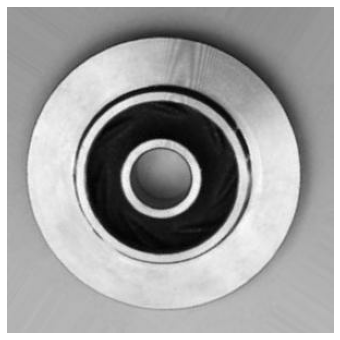

In [ ]:
# import tensorflow as tf
# import matplotlib.pyplot as plt
# plt.rc('figure', autolayout=True)
# plt.rc('axes', labelweight='bold', labelsize='large',
#        titleweight='bold', titlesize=18, titlepad=10)
# plt.rc('image', cmap='magma')

image_path = technocast_train_path + '/ok_front/cast_ok_0_1.jpeg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

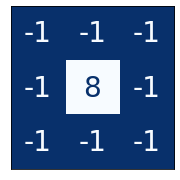

In [ ]:
import tensorflow as tf

kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)

In [ ]:
# Reformat for batch compatibility.
image = tf.image.rgb_to_grayscale(image)
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

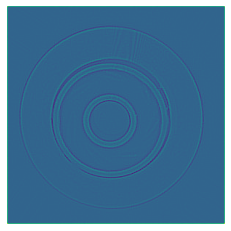

In [ ]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    # we'll talk about these two in lesson 4!
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

And now the ReLU step:

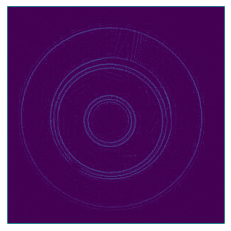

In [ ]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

### 3.2.5 Condense with Maximum Pooling

In this last step that we'll cover, we're going to condense the image in a way that accentuates the identified features. This is done with `MaxPool2D` layer in keras



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

A `MaxPool2D` layer isn't much different from a `Conv2D` layer other than that, instead of taking a sum, the kernel (not really a kernel) just returns the maximum value. `kernel_size` is replaced with `pool_size` and there are no trainable weights.

<p align=center>
<img src="https://imgur.com/hK5U2cd.png" width=400></img>

Features are indeed intensified by the max pooling, but another way to think of this is that carrying all those empty "black" pixels through the network is computationally expensive without adding much information. Max pooling is a quick and dirty way of consolidating the network and retaining only the most salient information.

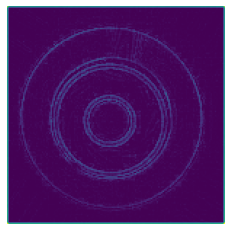

In [ ]:
image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(4, 4))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

## 3.3 Exercise: Practice with Global Average Pooling

Usually at the end of the convolutional blocks, we use a `Flatten()` layer to convert the 2D arrays of feature maps to 1D to feed into the Dense layers of the network. Another method that has become popular is to use **_Global Average Pooling_**. With this schematic, each feature map is turned into an average. By this method, the head of the CNN now only has to make a classificaiton based on how _turned on_ the feature maps are, indicated by the result of the global average pooling. We would implement this with keras like so:

```
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

Try replacing the Flatten layer with GlobalAvgPool2D and see if it improves the model.

In [ ]:
#importing required libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
path_to_casting_data = '/content/drive/MyDrive/ds_for_engineers/data/casting_defects/casting_data/'

image_shape = (300,300,1)
batch_size = 32

technocast_train_path = path_to_casting_data + 'train/'
technocast_test_path = path_to_casting_data + 'test/'

image_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalzing it)

#we using keras inbuild function to ImageDataGenerator so we 
# dont need to label all images into 0 and 1 
print("loading training set...")
train_set = image_gen.flow_from_directory(technocast_train_path,
                                          target_size=image_shape[:2],
                                          color_mode="grayscale",
                                          batch_size=batch_size,
                                          class_mode='binary',shuffle=True)
print("loading testing set...")
test_set = image_gen.flow_from_directory(technocast_test_path,
                                          target_size=image_shape[:2],
                                          color_mode="grayscale",
                                          batch_size=batch_size,
                                          class_mode='binary',shuffle=False)

loading training set...
Found 6643 images belonging to 2 classes.
loading testing set...
Found 715 images belonging to 2 classes.


In [ ]:
ds_iter = iter(train_set)

In [ ]:
#Creating model
image_shape=[300,300,1]
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(layers.GlobalAvgPool2D())

In [ ]:
car = next(ds_iter)
print(car.shape)
car_tf = tf.image.resize(car[0], size=image_shape[:2])
car_features = model(car_tf)

AttributeError: ignored

In [ ]:

car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show();

ValueError: ignored